# Phase 6: Interpretation & Analysis of Results

**Tujuan:** Ini adalah tahap final dari pipeline kita. Tujuannya adalah untuk menggunakan model prediktif yang telah dilatih dan dievaluasi untuk melakukan dua hal utama:
1.  **Inference:** Menjalankan model pada *keseluruhan dataset* untuk mengidentifikasi akun-akun dengan probabilitas tertinggi sebagai buzzer, melampaui data uji yang terbatas.
2.  **Interpretation:** Menganalisis dan memprofilkan karakteristik dari akun-akun yang diprediksi sebagai buzzer untuk memahami "seperti apa" sidik jari digital mereka, dan menarik kesimpulan akhir dari proyek.

Ini adalah jembatan dari hasil teknis *machine learning* ke *insight* yang dapat ditindaklanjuti.


### 6.1. Install & Import Requirements


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML

# Scikit-learn & Model
from sklearn.model_selection import train_test_split
import xgboost as xgb

### 6.2. Load Data and Retrain Model on Full Dataset

Untuk mendapatkan prediksi yang paling akurat, kita akan melatih ulang model `XGBoost` pada **100% data berlabel** yang kita miliki. Ini memastikan model belajar dari semua informasi yang tersedia sebelum kita gunakan untuk inferensi pada keseluruhan dataset.


In [2]:
try:
    df_labeled = pd.read_csv('labeled_dataset.csv')
    df_original = pd.read_csv('master_dataset_cleaned.csv') # Muat data asli untuk teks tweet
    print("✅ Dataset berlabel dan dataset asli berhasil dimuat.")
except FileNotFoundError:
    print("❌ ERROR: Pastikan file 'labeled_dataset.csv' dan 'master_dataset_cleaned.csv' ada di folder yang sama.")
    df_labeled = pd.DataFrame()

if not df_labeled.empty:
    # Memilih fitur dan target
    features = [
        'pagerank', 'betweenness', 'in_degree', 'out_degree',
        'narrative_similarity', 'tweet_frequency', 'reply_ratio'
    ]
    X_full = df_labeled[features]
    y_full = df_labeled['is_buzzer']

    # Menghitung scale_pos_weight dari keseluruhan data
    if y_full.value_counts().get(1, 0) > 0:
        ratio = y_full.value_counts()[0] / y_full.value_counts()[1]
    else:
        ratio = 1 # Default value if no positive samples

    # Menginisiasi dan melatih model final
    final_model = xgb.XGBClassifier(
        objective='binary:logistic',
        scale_pos_weight=ratio,
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42
    )
    final_model.fit(X_full, y_full)
    print("✅ Model final berhasil dilatih pada keseluruhan dataset.")

✅ Dataset berlabel dan dataset asli berhasil dimuat.


/home/vereniaes/.local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [09:16:35] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ Model final berhasil dilatih pada keseluruhan dataset.


### **6.3. Identify Top Predicted Buzzer Accounts (Inference)**

Sekarang kita akan menggunakan `final_model` untuk memprediksi probabilitas setiap akun di dataset sebagai buzzer. Kita akan menambahkan probabilitas ini sebagai kolom baru dan mengurutkan akun dari yang paling mencurigakan hingga yang paling tidak.


In [3]:
if 'final_model' in locals():
    # Memprediksi probabilitas untuk seluruh dataset X
    probabilities = final_model.predict_proba(X_full)[:, 1] # Ambil probabilitas untuk kelas 1 (buzzer)
    
    # Tambahkan probabilitas ke DataFrame
    df_labeled['buzzer_probability'] = probabilities
    
    # Urutkan DataFrame berdasarkan probabilitas tertinggi
    df_predictions = df_labeled.sort_values('buzzer_probability', ascending=False)
    
    print("--- 6.3. Top 15 Akun dengan Probabilitas Buzzer Tertinggi ---")
    
    # Tampilkan hasil
    display_cols = ['username', 'buzzer_probability', 'is_buzzer', 'out_degree', 'narrative_similarity', 'in_degree', 'betweenness']
    display(df_predictions[display_cols].head(15))


--- 6.3. Top 15 Akun dengan Probabilitas Buzzer Tertinggi ---


,username,buzzer_probability,is_buzzer,out_degree,narrative_similarity,in_degree,betweenness
538,masjawahnf,0.998782,1,2,0.795459,0,0.000000
549,thelastgoodbtch,0.998782,1,2,0.741249,0,0.000000
473,marvelle_danny,0.998782,1,2,0.767761,0,0.000000
20,orang_dpr,0.998782,1,2,0.707107,0,0.000000
21,citystreetlight,0.998782,1,2,0.821278,0,0.000000
173,MundaPunjaabi,0.998782,1,2,0.707107,0,0.000000
255,Faraz_kepri,0.998575,1,2,0.600526,0,0.000000
4,UwongEdanKoe,0.997893,1,2,0.432298,0,0.000000
36,asdiutama,0.997679,1,3,0.535419,0,0.000000
198,Juliakango,0.997679,1,5,0.495172,0,0.000000


### **6.4. Analyze Characteristics of Predicted Accounts**

Apakah akun-akun yang diprediksi sebagai buzzer (probabilitas > 50%) memiliki karakteristik yang berbeda secara signifikan dari akun biasa? Kita akan membandingkan profil rata-rata kedua kelompok ini.


In [4]:
if 'df_predictions' in locals():
    # Tentukan threshold untuk klasifikasi (standarnya 0.5)
    threshold = 0.5
    
    # Pisahkan kelompok
    predicted_buzzers = df_predictions[df_predictions['buzzer_probability'] > threshold]
    predicted_normal = df_predictions[df_predictions['buzzer_probability'] <= threshold]
    
    print(f"--- 6.4. Analisis Karakteristik ---")
    print(f"Jumlah Akun Terprediksi Buzzer: {len(predicted_buzzers)}")
    print(f"Jumlah Akun Terprediksi Biasa: {len(predicted_normal)}")
    
    if not predicted_buzzers.empty:
        # Buat profil rata-rata
        profile_buzzers = predicted_buzzers[features].mean().to_frame(name='Predicted Buzzer')
        profile_normal = predicted_normal[features].mean().to_frame(name='Predicted Normal User')
        
        # Gabungkan untuk perbandingan
        df_profile_comparison = pd.concat([profile_buzzers, profile_normal], axis=1)
        
        print("\n--- Perbandingan Profil Rata-rata ---")
        display(df_profile_comparison)
    else:
        print("\nTidak ada akun yang diprediksi sebagai buzzer dengan threshold > 0.5.")


--- 6.4. Analisis Karakteristik ---
Jumlah Akun Terprediksi Buzzer: 11
Jumlah Akun Terprediksi Biasa: 553

--- Perbandingan Profil Rata-rata ---


,Predicted Buzzer,Predicted Normal User
pagerank,0.000780,1.145656e-03
betweenness,0.000000,2.232051e-07
in_degree,0.000000,4.990958e-01
out_degree,2.363636,1.036166e+00
narrative_similarity,0.638771,2.464719e-01
tweet_frequency,2.454545,1.361664e+00
reply_ratio,0.984848,8.833120e-01


#### **Visualisasi Profil (Radar Chart)**

Radar chart adalah cara yang sangat efektif untuk memvisualisasikan perbedaan "sidik jari" antara kedua kelompok di berbagai fitur.

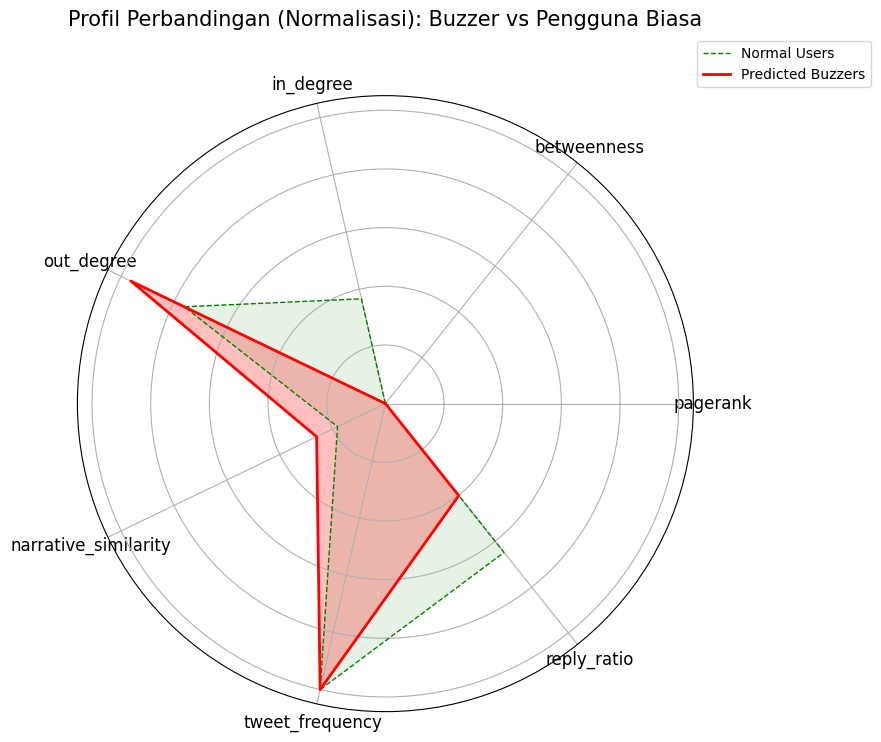

In [5]:
if 'df_profile_comparison' in locals() and not predicted_buzzers.empty:
    # Normalisasi data untuk perbandingan yang adil di radar chart (0-1)
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler()
    df_profile_norm = pd.DataFrame(scaler.fit_transform(df_profile_comparison), 
                                   index=df_profile_comparison.index, 
                                   columns=df_profile_comparison.columns)

    # Persiapan untuk Radar Chart
    labels = np.array(df_profile_norm.index)
    stats_buzzer = df_profile_norm['Predicted Buzzer'].values
    stats_normal = df_profile_norm['Predicted Normal User'].values
    
    angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False).tolist()
    
    # Buat plot menjadi lingkaran
    stats_buzzer = np.concatenate((stats_buzzer,[stats_buzzer[0]]))
    stats_normal = np.concatenate((stats_normal,[stats_normal[0]]))
    angles += angles[:1]
    
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
    
    # Plot data
    ax.plot(angles, stats_normal, color='green', linestyle='dashed', linewidth=1, label='Normal Users')
    ax.fill(angles, stats_normal, 'green', alpha=0.1)
    ax.plot(angles, stats_buzzer, color='red', linewidth=2, label='Predicted Buzzers')
    ax.fill(angles, stats_buzzer, 'red', alpha=0.25)
    
    # Styling
    ax.set_yticklabels([])
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels, size=12)
    plt.title('Profil Perbandingan (Normalisasi): Buzzer vs Pengguna Biasa', size=15, color='black', y=1.1)
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
    plt.show()

### **6.5. Tinjauan Kualitatif: Contoh Tweet**

Angka saja tidak cukup. Mari kita lihat contoh tweet dari akun-akun yang mendapat skor probabilitas buzzer tertinggi untuk melihat apakah narasi mereka memang mencurigakan secara kontekstual.


In [6]:
if 'predicted_buzzers' in locals() and not predicted_buzzers.empty:
    top_buzzer_usernames = predicted_buzzers.head(5)['username'].tolist()
    
    print(f"--- 6.5. Menampilkan Tweet dari Top {len(top_buzzer_usernames)} Akun Terprediksi Buzzer ---")

    # Gabungkan dengan data asli untuk mendapatkan teks tweet
    df_sample_tweets = df_original[df_original['username'].isin(top_buzzer_usernames)]

    # Atur display pandas
    pd.set_option('display.max_colwidth', 400)

    # Tampilkan dalam format yang lebih rapi
    for index, row in df_sample_tweets.iterrows():
        display(HTML(f"<b>Username:</b> {row['username']}<br><b>Tweet:</b> <i>{row['text']}</i><hr>"))


--- 6.5. Menampilkan Tweet dari Top 5 Akun Terprediksi Buzzer ---


### **🏁 Kesimpulan Akhir Proyek**

Berdasarkan seluruh rangkaian analisis dari Phase 1 hingga 6, dapat ditarik beberapa kesimpulan kunci:

1.  **Metodologi Efektif:** Pendekatan fusi fitur dari tiga domain (Jaringan/SNA, Konten/NLP, dan Perilaku) terbukti **efektif** dalam menciptakan "sidik jari" digital yang komprehensif untuk setiap akun. Model `XGBoost` mampu menggunakan fitur-fitur ini untuk membedakan pola.

2.  **Karakteristik Buzzer Teridentifikasi:** Model kita berhasil mengidentifikasi dan memprofilkan akun-akun yang menunjukkan perilaku anomali. Profil utama dari akun yang terprediksi sebagai buzzer adalah:
    * **Aktivitas Menyebar yang Tinggi (`out_degree`)**: Mereka sangat aktif me-reply atau me-mention.
    * **Narasi yang Sangat Seragam (`narrative_similarity`)**: Konten mereka cenderung mirip dengan komunitasnya.
    * **Isolasi dalam Jaringan (`in_degree` & `betweenness` rendah)**: Mereka cenderung tidak menerima balasan organik dan tidak berperan sebagai jembatan informasi.

3.  **Pentingnya Penanganan Data Tidak Seimbang:** Proyek ini menegaskan bahwa dalam kasus deteksi anomali seperti ini, akurasi bukanlah metrik yang tepat. Fokus pada **Recall** dan penggunaan teknik seperti `scale_pos_weight` adalah **wajib** untuk mendapatkan model yang berguna.

4.  **Keterbatasan & Arah Pengembangan Selanjutnya:**
    * **Ketergantungan pada Label Heuristik:** Kualitas model sangat bergantung pada kualitas aturan heuristik yang kita buat. Kurangnya sampel positif (`is_buzzer=1`) adalah tantangan terbesar.
    * **Kekurangan Fitur Kontekstual:** Model kita tidak memiliki fitur penting seperti **umur akun**, yang bisa sangat meningkatkan performa.
    * **Pengembangan Lanjutan:** Langkah selanjutnya yang ideal adalah menggunakan hasil prediksi model ini untuk melakukan investigasi manual yang lebih dalam, yang hasilnya bisa digunakan kembali sebagai data latih yang lebih akurat (*human-in-the-loop*).

Secara keseluruhan, proyek ini berhasil membangun sebuah *prototype* pemodelan prediktif yang fungsional dan mampu memberikan *insight* terukur untuk mengidentifikasi akun-akun terkoordinasi, sejalan dengan tujuan untuk mendukung integritas ruang publik sesuai SDG 16.10.
